In [1]:
from statlib.cauchy import Cauchy, Uniform
from statlib.rand.engine import LCG
from matplotlib import pyplot as plt
from ipywidgets import interact, IntSlider, fixed
import numpy as np

### Создадим генератор случайной величины

In [2]:
gen = LCG()

par = Cauchy(gen)
uniform = Uniform(gen)

### Проверим гипотезу равномерности генератора

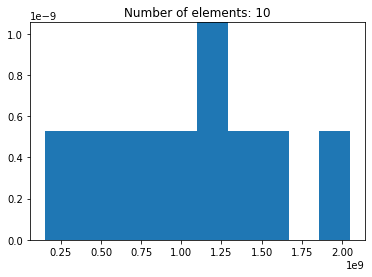

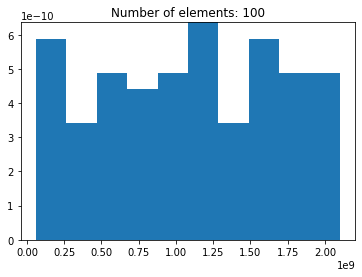

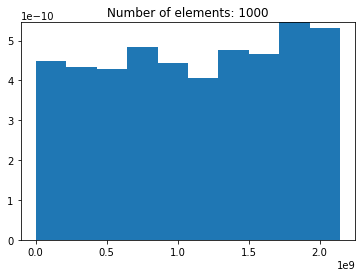

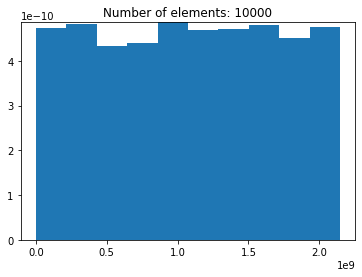

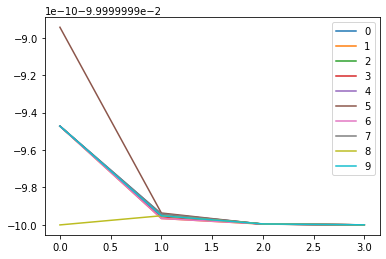

In [4]:
def test_uniformity(gen, iterations):
    vals = []
    for n in iterations:
        z = [gen.next() for _ in range(n)]
        vals.append(plt.hist(z, density=True)[0] / n)
        vals[-1] -= 1 / len(vals[-1])
        plt.title('Number of elements: {0}'.format(n))
        plt.show()
    
    # for each column plot differense with 1 / k
    vals = np.array(vals)
    nbins = len(vals[0])
    for i in range(nbins):
        plt.plot(vals[:, i], label=str(i))
    
    plt.legend()
    plt.show()
    
test_uniformity(gen, [10, 100, 1000, 10000])

In [13]:
#interact(test_uniformity, gen=fixed(gen), iterations=[10, 100, 1000, 10000]);

### Проверим независимость

In [15]:
def test_independence(gen, iterations, s=3):
    for n in iterations:
        z = np.array([gen.next() for _ in range(n)])
        mx = sum(z) / n
        dx = sum((z - mx) ** 2) / (n - 1)
            
        mxy = sum(z[i] * z[i + s] for i in range(n - s)) / (n - s)
        r = (mxy - mx * mx) / dx
        
        print('n: {:6}, r: {:.5}'.format(n, r))
    
test_independence(gen, [10, 100, 1000, 10000])

n:     10, r: 0.48011
n:    100, r: -0.20862
n:   1000, r: 0.012118
n:  10000, r: 0.0056073


In [60]:
def count(x, l, r):   
    print(x)
    return len(map(x, lambda t: l <= t <= r))


def pairs(x, y):
    p = []
    for xi in x:
        for yi in y:
            p.append((xi, yi))
    return p

def split(a, k):
    splits = []
    ranges = np.linspace(min(a), max(a), num=k)
    for i in range(len(ranges) - 1):
        l = ranges[i]
        r = ranges[i + 1]
        splits.append((l, r))
    return splits

def build_intervals(x, y, k, m):
    x.sort()
    y.sort()
    x_k = split(x, k)
    y_m = split(y, m)
    
    v = np.zeros((k - 1, m - 1))
    g = pairs(x, y)

    for i, (xl, xr) in enumerate(x_k):
        for j, (yl, yr) in enumerate(y_m):
            cnt = 0
            for xi, yi in g:
                if xl <= xi <= xr and yl <= yi <= yr:
                    cnt += 1
            v[i, j] = cnt
    print(v)

x_var_u = np.array([uniform.next(0, 1) for _ in range(100)])
build_intervals(x_var_u[::2], x_var_u[1::2], 10, 10)

[[42. 42. 28. 49. 56. 49. 14. 14. 56.]
 [30. 30. 20. 35. 40. 35. 10. 10. 40.]
 [24. 24. 16. 28. 32. 28.  8.  8. 32.]
 [24. 24. 16. 28. 32. 28.  8.  8. 32.]
 [12. 12.  8. 14. 16. 14.  4.  4. 16.]
 [48. 48. 32. 56. 64. 56. 16. 16. 64.]
 [42. 42. 28. 49. 56. 49. 14. 14. 56.]
 [24. 24. 16. 28. 32. 28.  8.  8. 32.]
 [54. 54. 36. 63. 72. 63. 18. 18. 72.]]


#### Начальные параметры для гистограмм

In [132]:
def get_bins_count(n):
    if n <= 100:
        return int(np.sqrt(n))
    else:
        return 4 * int(np.log10(n))

n = 100000
segments = get_bins_count(n)

### Равноинтервальная гистограмма

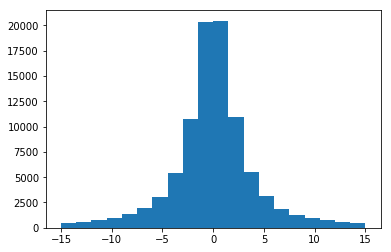

In [133]:
res = []
ranges = (-15, 15)
x0 = 0
gamma = 2

for _ in range(n):
    res.append(par.next(x0, gamma))

x_var_f = [x for x in x_var if x >= ranges[0] and x <= ranges[1]]
vals, bins, patches = plt.hist(res, bins=segments, range=ranges)

In [134]:
x_var = sorted(res)
counts = {}
for x in x_var:
    counts[x] = counts.get(x, 0) + 1
    
F = [0]
for i in range(len(x_var) - 1):
    F.append(F[i] + counts[x_var[i]] / n)

def distr_fun(x):
    for i in range(1, len(x_var)):
        if x_var[i - 1] <= x < x_var[i]:
            return F[i - 1]
    return 1

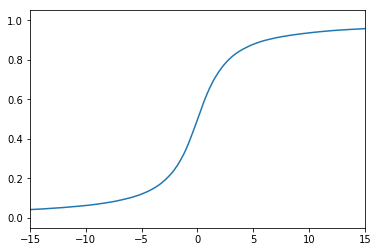

In [136]:
plt.xlim(ranges)
_ = plt.step(sorted(res), F)

### Равновероятностная гистограмма

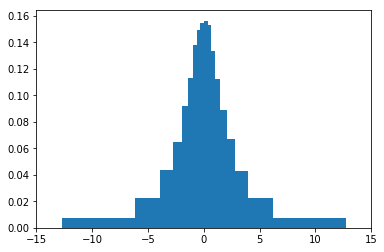

In [137]:
borders_eq = [x_var[0]] + [(x_var[i] + x_var[i + 1]) / 2 for i in range(n // segments - 1, n - 1, n // segments)] + [x_var[-1]]

plt.xlim(ranges)
vals_int, bins_int, patches_int = plt.hist(x_var, bins=borders_eq, density=True)

### Точечная оценка медианы

In [138]:
def find_median(bins, vals):
    med_amount = sum(vals) / 2
    h = bins[1] - bins[0]
    cur_sum = 0
    i = 0
    while cur_sum < med_amount:
        cur_sum += vals[i]
        i += 1

    return bins[i] + h * (med_amount - cur_sum + vals[i]) / vals[i]

med_p = find_median(bins, vals)
print(med_p)

0.22121906507791023


### Точечная оценка моды

In [139]:
def find_mode(bins, vals):
    mode_pos = 0
    max_val = 0
    h = bins[1] - bins[0]
    
    for i, val in enumerate(vals):
        if val > max_val:
            max_val = val
            mode_pos = i
   
    prev_pos = i - 1 if i - 1 >= 0 else 0
    next_pos = i + 1 if i + 1 < len(vals) else 0
    
    return bins[mode_pos] + h * (vals[mode_pos] - vals[prev_pos]) / (vals[mode_pos] - vals[prev_pos] + vals[mode_pos] - vals[next_pos])

mod_p = find_mode(bins, vals)
print(mod_p)

0.7479307750188111


In [141]:
def get_median_confidense(x_var, a=0.05):
    n = len(x_var)
    if a == 0.1:
        k = 0.5 * (n - 1.64 * np.sqrt(n) - 1)
    if a == 0.05:
        k = 0.5 * (n - 1.96 * np.sqrt(n) - 1)
    if a == 0.01:
        k = 0.5 * (n - 2.58 * np.sqrt(n) - 1)
    
    k = int(k)
    return x_var[k], x_var[n - k + 1]

get_median_confidense(x_var_f)

(-0.008328224830285235, 0.028083844493106216)

### Проверим критерий согласия Пирсона

In [142]:
import math

# distribution function
def get_F(x0, gamma):
    def F(x):
        return 1 / math.pi * np.arctan((x - x0) / gamma) + 1 / 2
    
    return F

def pearson_chi(bins, vals, F):
    n = sum(vals)
    chi = 0
    for i in range(len(bins) - 1):
        l = bins[i]
        r = bins[i + 1]
        pi_s = F(r) - F(l)
        pi = vals[i] / n
        chi += (pi - pi_s)**2 / pi
    
    return chi * len(bins)


from scipy.stats import chi2

chi_sqr = pearson_chi(bins, vals, get_F(x0, gamma))
table_pearson = chi2.ppf(0.05, len(bins))
print('Experimental chi square: {cs}, Table chi square: {ts}'.format(cs=chi_sqr, ts=table_pearson))
if chi_sqr < table_pearson:
    print('Good')

Experimental chi square: 0.15261355933851842, Table chi square: 11.591305208820735
Good
